In [1]:
import pandas as pd
df = pd.read_csv('c:/data/spam/spam.csv',encoding='latin1')
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [2]:
# ham => 0, spam => 1 로 바꾸어 저장
df['v1'] = df['v1'].replace(['ham','spam'],[0,1])
df[:5]

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.shape

(5572, 2)

0    4825
1     747
Name: v1, dtype: int64


<AxesSubplot:>

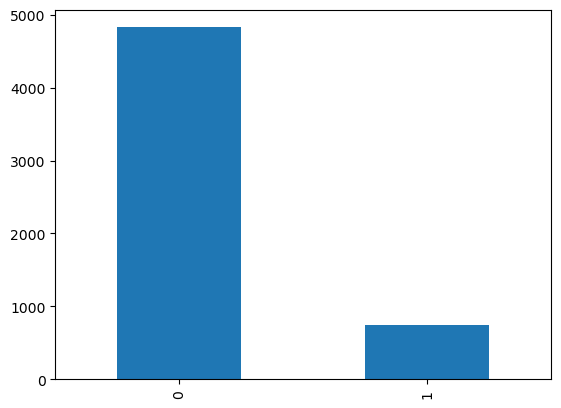

In [4]:
print(df['v1'].value_counts())
df['v1'].value_counts().plot(kind='bar')

In [5]:
X=df[['v2']] #독립변수
y=df['v1'] #종속변수
print(X[:3])
print(y[:3])

                                                  v2
0  Go until jurong point, crazy.. Available only ...
1                      Ok lar... Joking wif u oni...
2  Free entry in 2 a wkly comp to win FA Cup fina...
0    0
1    0
2    1
Name: v1, dtype: int64


0    747
1    747
Name: v1, dtype: int64


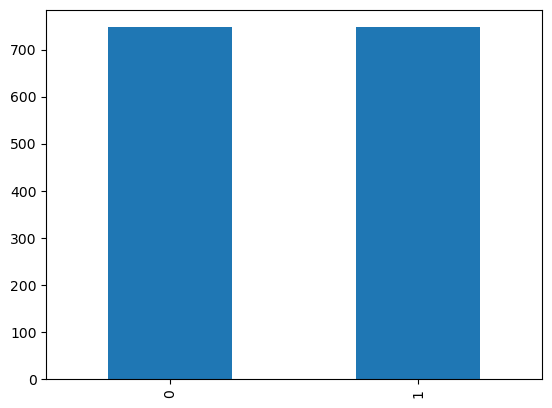

In [6]:
#언더샘플링
from imblearn.under_sampling import RandomUnderSampler
X_sample, y_sample = RandomUnderSampler(random_state=0).fit_resample(X, y)
X_samp = pd.DataFrame(data=X_sample,columns=['v2'] )
y_samp = pd.DataFrame(data=y_sample,columns=['v1'])
df_samp=pd.concat([X_samp,y_samp],axis=1)
print(df_samp['v1'].value_counts())
df_samp['v1'].value_counts().plot(kind='bar')
X = df_samp['v2']
y = df_samp['v1']

In [7]:
from keras.preprocessing.text import Tokenizer
#단어 집합을 만들고 단어에 고유한 숫자 인덱스를 부여
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
#텍스트를 시퀀스로 변환(단어의 인덱스로만 구성된 새로운 리스트)
sequences = tokenizer.texts_to_sequences(X)
print(sequences[:5])

[[1486, 49, 801, 1487, 18, 336, 87, 26, 2274, 45, 27, 173], [1148, 14, 4, 25, 613], [174, 149, 4, 2, 189, 5, 105, 17, 614, 613], [946, 88, 38, 399, 702, 1, 2275, 1488, 130, 2276, 26, 1489, 242, 45, 702, 1, 2277, 2278, 24, 46, 1149], [7, 291, 1490, 802, 553, 53, 316, 26, 803, 703, 25, 63, 47, 217, 1491, 13, 434, 337, 97]]


In [8]:
#단어와 인덱스 목록
word_to_index = tokenizer.word_index
#word_to_index
for idx,word in enumerate(word_to_index):
    print(idx+1,word, end=',')
    if idx>8:
        break 

1 to,2 you,3 a,4 call,5 i,6 the,7 u,8 your,9 for,10 is,

In [9]:
X_data = sequences
b= sum(map(len, X_data))/len(X_data)

메일의 최대 길이 : 77
메일의 평균 길이 : 19.846051


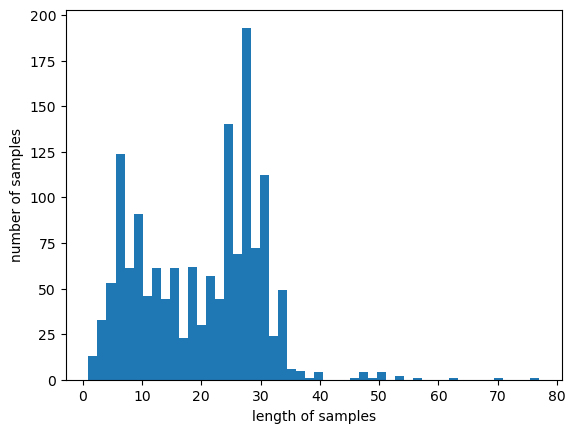

In [10]:
import matplotlib.pyplot as plt

print('메일의 최대 길이 : %d' % max(len(l) for l in X_data))
print('메일의 평균 길이 : %f' % b)
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of samples') # 길이
plt.ylabel('number of samples') # 샘플수
plt.show()

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
#최대 사이즈에 맞추어 빈칸에 0으로 채움
data = pad_sequences(X_data, maxlen = 77)
print("학습용 데이터의 크기(shape): ", data.shape)
print(data[:1])

학습용 데이터의 크기(shape):  (1494, 77)
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0 1486   49  801 1487   18
   336   87   26 2274   45   27  173]]


In [12]:
#학습용:검증용 8:2 구분
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, stratify=y, random_state=10)

In [38]:
#순환신경망_SimpleRNN
from keras.layers import Embedding, Dense, LSTM, SimpleRNN
from keras.models import Sequential
model = Sequential()
#Embedding(입력사이즈, 출력사이즈)
model.add(Embedding(len(word_to_index)+1, 32))
model.add(SimpleRNN(32)) #output size 32
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          149120    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 151,233
Trainable params: 151,233
Non-trainable params: 0
_________________________________________________________________


In [33]:
hist = model.fit(X_train, y_train.values, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
15/15 [==============================] - 3s 116ms/step - loss: 0.5797 - accuracy: 0.7374 - val_loss: 0.4408 - val_accuracy: 0.8326
Epoch 2/10
15/15 [==============================] - 1s 99ms/step - loss: 0.3639 - accuracy: 0.8682 - val_loss: 0.2938 - val_accuracy: 0.9372
Epoch 3/10
15/15 [==============================] - 2s 110ms/step - loss: 0.2152 - accuracy: 0.9508 - val_loss: 0.2722 - val_accuracy: 0.9163
Epoch 4/10
15/15 [==============================] - 2s 103ms/step - loss: 0.1561 - accuracy: 0.9665 - val_loss: 0.1616 - val_accuracy: 0.9540
Epoch 5/10
15/15 [==============================] - 2s 108ms/step - loss: 0.0969 - accuracy: 0.9833 - val_loss: 0.1461 - val_accuracy: 0.9665
Epoch 6/10
15/15 [==============================] - 2s 110ms/step - loss: 0.0681 - accuracy: 0.9885 - val_loss: 0.2122 - val_accuracy: 0.9331
Epoch 7/10
15/15 [==============================] - 2s 112ms/step - loss: 0.2132 - accuracy: 0.9142 - val_loss: 0.2306 - val_accuracy: 0.9205
Epoch 8

In [34]:
model.evaluate(X_test, y_test.values, verbose=0)

[0.10445131361484528, 0.9698996543884277]

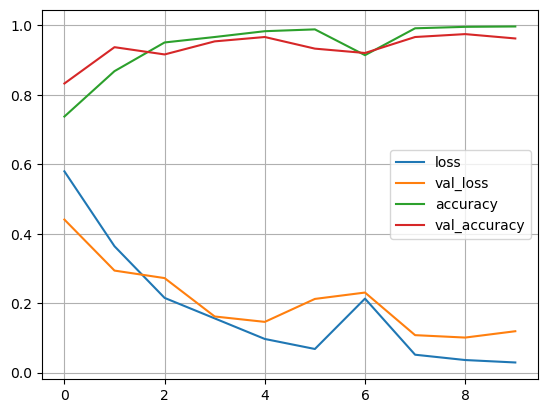

In [35]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['loss','val_loss','accuracy','val_accuracy'])
plt.grid()
plt.show()

In [36]:
model.predict(X_test[:3])

1/1 [==============================] - 0s 132ms/step


array([[0.987523  ],
       [0.03172332],
       [0.982537  ]], dtype=float32)

In [39]:
#순환신경망_LSTM
from keras.layers import Embedding, Dense, LSTM, SimpleRNN
from keras.models import Sequential
model = Sequential()
#Embedding(입력사이즈, 출력사이즈)
model.add(Embedding(len(word_to_index)+1, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          149120    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 157,473
Trainable params: 157,473
Non-trainable params: 0
_________________________________________________________________


In [40]:
hist = model.fit(X_train, y_train.values, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
15/15 [==============================] - 3s 49ms/step - loss: 0.6335 - accuracy: 0.7385 - val_loss: 0.5044 - val_accuracy: 0.8285
Epoch 2/10
15/15 [==============================] - 0s 10ms/step - loss: 0.4408 - accuracy: 0.8912 - val_loss: 0.3852 - val_accuracy: 0.8745
Epoch 3/10
15/15 [==============================] - 0s 10ms/step - loss: 0.2939 - accuracy: 0.9362 - val_loss: 0.2613 - val_accuracy: 0.9414
Epoch 4/10
15/15 [==============================] - 0s 10ms/step - loss: 0.2031 - accuracy: 0.9477 - val_loss: 0.2017 - val_accuracy: 0.9372
Epoch 5/10
15/15 [==============================] - 0s 10ms/step - loss: 0.1343 - accuracy: 0.9707 - val_loss: 0.1414 - val_accuracy: 0.9623
Epoch 6/10
15/15 [==============================] - 0s 10ms/step - loss: 0.0904 - accuracy: 0.9812 - val_loss: 0.1081 - val_accuracy: 0.9749
Epoch 7/10
15/15 [==============================] - 0s 10ms/step - loss: 0.0684 - accuracy: 0.9843 - val_loss: 0.1194 - val_accuracy: 0.9623
Epoch 8/10
15

In [41]:
model.evaluate(X_test, y_test.values, verbose=0)

[0.08421390503644943, 0.9765886068344116]

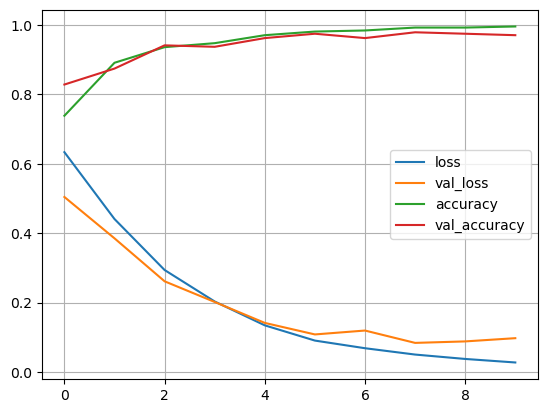

In [42]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['loss','val_loss','accuracy','val_accuracy'])
plt.grid()
plt.show()

In [43]:
model.predict(X_test[:3])

1/1 [==============================] - 0s 335ms/step


array([[0.98486346],
       [0.02878128],
       [0.99257374]], dtype=float32)

In [18]:
#신경망
from keras.layers import Embedding, Dense, LSTM, SimpleRNN
from keras.models import Sequential
model = Sequential()
model.add(Dense(64, input_shape=(77,),  activation='relu'))
#                    독립변수의 수
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1195, 64)          4992      
                                                                 
 dense_4 (Dense)             (None, 1195, 32)          2080      
                                                                 
 dense_5 (Dense)             (None, 1195, 1)           33        
                                                                 
Total params: 7,105
Trainable params: 7,105
Non-trainable params: 0
_________________________________________________________________


In [14]:
hist = model.fit(X_train, y_train.values, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
15/15 [==============================] - 1s 17ms/step - loss: 98.7204 - accuracy: 0.5962 - val_loss: 73.6562 - val_accuracy: 0.5774
Epoch 2/10
15/15 [==============================] - 0s 6ms/step - loss: 51.6683 - accuracy: 0.6454 - val_loss: 54.1936 - val_accuracy: 0.5649
Epoch 3/10
15/15 [==============================] - 0s 6ms/step - loss: 36.2693 - accuracy: 0.6674 - val_loss: 50.5934 - val_accuracy: 0.5900
Epoch 4/10
15/15 [==============================] - 0s 6ms/step - loss: 29.8583 - accuracy: 0.6726 - val_loss: 43.9336 - val_accuracy: 0.6192
Epoch 5/10
15/15 [==============================] - 0s 6ms/step - loss: 21.2946 - accuracy: 0.7144 - val_loss: 42.1200 - val_accuracy: 0.5816
Epoch 6/10
15/15 [==============================] - 0s 7ms/step - loss: 17.9902 - accuracy: 0.7479 - val_loss: 42.1006 - val_accuracy: 0.6360
Epoch 7/10
15/15 [==============================] - 0s 6ms/step - loss: 14.7335 - accuracy: 0.7563 - val_loss: 38.2678 - val_accuracy: 0.6318
Epoch

In [15]:
model.evaluate(X_test, y_test.values, verbose=0)

[33.34364700317383, 0.6287625432014465]

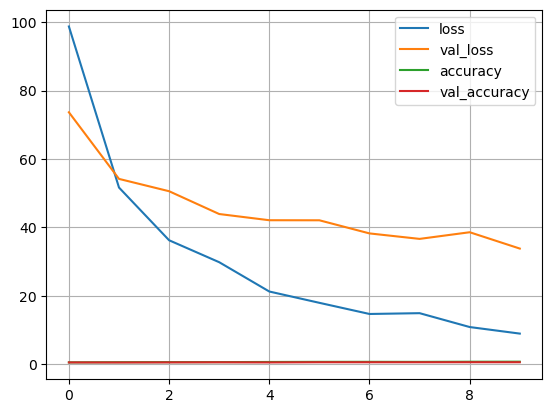

In [16]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['loss','val_loss','accuracy','val_accuracy'])
plt.grid()
plt.show()

In [17]:
model.predict(X_test[:3])

1/1 [==============================] - 0s 74ms/step


array([[0.9999261 ],
       [0.01601676],
       [1.        ]], dtype=float32)